# Higher-order Fluid Simulation

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/Higher_order_Kolmogorov.ipynb)

This notebook simulates Kolmogorov flow using higher-order spatial and temporal schemes.


In [1]:
%pip install phiflow
from phi.jax.flow import *
from tqdm.notebook import trange
math.set_global_precision(64)

The Kolmogorov flow uses a sinusoidal forcing along x which is added to the velocity at every time step.
We add a small perturbation in the form of `Noise` to violate symmetry and trigger a turbulent time development.

<Figure size 864x360 with 4 Axes>

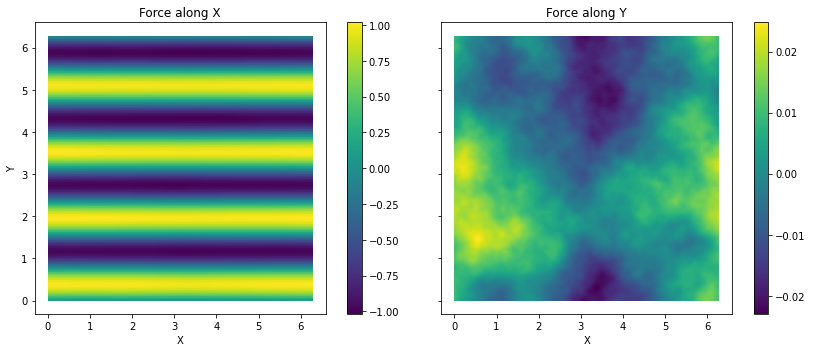

In [2]:
DOMAIN = dict(extrapolation=extrapolation.PERIODIC, bounds=Box(x=2*PI, y=2*PI), x=100, y=100)
FORCING = CenteredGrid(lambda x, y: vec(x=math.sin(4 * y), y=0), **DOMAIN) + CenteredGrid(Noise(), **DOMAIN) * 0.01
plot({'Force along X': FORCING['x'], 'Force along Y': FORCING['y']}, same_scale=False)

Next we define the momentum equation (PDE) for the incompressible flow.
We use 6th-order implicit advection and diffusion.
The pressure solve is integrated into Φ<sub>Flow</sub>'s 4th-order Runge-Kutta integrator `fluid.incompressible_rk4`. It uses a 4th-order direct scheme to avoid nested linear solves.

In [3]:
def momentum_equation(v, viscosity=0.001):
    advection = advect.finite_difference(v, v, order=6)
    diffusion = diffuse.finite_difference(v, viscosity, order=6)
    return advection + diffusion + FORCING

@jit_compile
def rk4_step(v, p, dt):
  return fluid.incompressible_rk4(momentum_equation, v, p, dt, pressure_order=4, pressure_solve=Solve('CG', 1e-5, 1e-5))

Let's run the simulation!

In [4]:
v0 = CenteredGrid(tensor([0, 0], channel(vector='x, y')), **DOMAIN)
p0 = CenteredGrid(0, **DOMAIN)
multi_step = lambda *x, **kwargs: iterate(rk4_step, 25, *x, **kwargs)
v_trj, p_trj = iterate(multi_step, batch(time=100), v0, p0, dt=0.005, range=trange)
vis.plot(field.curl(v_trj.with_extrapolation(0)), animate='time')

  0%|          | 0/100 [00:00<?, ?it/s]